<a href="https://colab.research.google.com/github/2000siddharth/relatas_assgn/blob/master/task_in_Spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt-get update

In [ ]:
!sudo apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [3]:
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.6/spark-2.4.6-bin-hadoop2.7.tgz
!tar xf spark-2.4.6-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.6-bin-hadoop2.7"
import findspark
findspark.init()

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Learning_Spark") \
    .getOrCreate()

In [5]:
data = spark.read.csv('/content/sales.csv',inferSchema=True, header =True)

In [6]:
data.show(5)

+---+----------+--------------+---------------+--------------------+--------------------+----------+--------------+-----------+-------------------+-------------------+--------+---------------+-------------+
|_c0|   Account|Opportunity_ID|    Sales_Agent|   SalesAgentEmailID|      ContactEmailID|Deal_Stage|       Product|Close_Value|       Created Date|         Close Date|DateDiff|Ordered_Product|Ordered_Agent|
+---+----------+--------------+---------------+--------------------+--------------------+----------+--------------+-----------+-------------------+-------------------+--------+---------------+-------------+
|  0|     Konex|      3KR50X38|  Corliss Cosme|corliss@piedpiper...|    delila@konex.com|         1|GTX Plus Basic|       1255|2016-01-04 00:00:00|2016-05-24 00:00:00|     141|              2|           21|
|  1|    Finjob|      YFS5KLJJ|Rosalina Dieter|rosalina@piedpipe...|  belinda@finjob.com|         1|    MG Special|         45|2016-01-04 00:00:00|2016-11-02 00:00:00|     

In [6]:
data = data.select(['Deal_Stage', 'Close_Value', 'DateDiff', 'Ordered_Product', 'Ordered_Agent'])
data.show(10)

+----------+-----------+--------+---------------+-------------+
|Deal_Stage|Close_Value|DateDiff|Ordered_Product|Ordered_Agent|
+----------+-----------+--------+---------------+-------------+
|         1|       1255|     141|              2|           21|
|         1|         45|     303|              6|           20|
|         0|       1054|     336|              6|            2|
|         0|        517|     256|              1|           27|
|         1|       3180|      24|              1|            0|
|         1|        517|     335|              4|            7|
|         1|       5539|     328|              3|            9|
|         1|       4359|      18|              3|           12|
|         1|         41|     353|              6|            6|
|         1|       5169|     292|              5|           22|
+----------+-----------+--------+---------------+-------------+
only showing top 10 rows



In [7]:
from pyspark.ml.feature import VectorAssembler

# specify the input and output columns of the vector assembler
assembler = VectorAssembler(inputCols=['Close_Value',
                                       'DateDiff',
                                       'Ordered_Product',                                       
                                       'Ordered_Agent'],
                           outputCol='features')

# transform the data
final_data = assembler.transform(data)

# view the transformed vector
final_data=final_data.select(['features', 'Deal_Stage'])
final_data.show(10)

+--------------------+----------+
|            features|Deal_Stage|
+--------------------+----------+
|[1255.0,141.0,2.0...|         1|
|[45.0,303.0,6.0,2...|         1|
|[1054.0,336.0,6.0...|         0|
|[517.0,256.0,1.0,...|         0|
|[3180.0,24.0,1.0,...|         1|
|[517.0,335.0,4.0,...|         1|
|[5539.0,328.0,3.0...|         1|
|[4359.0,18.0,3.0,...|         1|
|[41.0,353.0,6.0,6.0]|         1|
|[5169.0,292.0,5.0...|         1|
+--------------------+----------+
only showing top 10 rows



In [8]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(final_data)

# Normalize each feature to have unit standard deviation.
scaledData = scalerModel.transform(final_data)
scaledData.show()

+--------------------+----------+--------------------+
|            features|Deal_Stage|      scaledFeatures|
+--------------------+----------+--------------------+
|[1255.0,141.0,2.0...|         1|[0.54853113110482...|
|[45.0,303.0,6.0,2...|         1|[0.01966844693204...|
|[1054.0,336.0,6.0...|         0|[0.46067873480835...|
|[517.0,256.0,1.0,...|         0|[0.22596860141927...|
|[3180.0,24.0,1.0,...|         1|[1.38990358319788...|
|[517.0,335.0,4.0,...|         1|[0.22596860141927...|
|[5539.0,328.0,3.0...|         1|[2.42096727903556...|
|[4359.0,18.0,3.0,...|         1|[1.90521689281747...|
|[41.0,353.0,6.0,6.0]|         1|[0.01792014053808...|
|[5169.0,292.0,5.0...|         1|[2.25924893759429...|
|[3284.0,310.0,1.0...|         1|[1.43535954944083...|
|[1164.0,18.0,2.0,...|         1|[0.50875716064224...|
|[1233.0,84.0,2.0,...|         1|[0.53891544593804...|
|[578.0,303.0,4.0,...|         1|[0.25263027392716...|
|[54.0,306.0,6.0,2...|         1|[0.02360213631845...|
|[1070.0,2

In [9]:
train, test = scaledData.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 4691
Test Dataset Count: 2020


In [12]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'scaledFeatures', labelCol = 'Deal_Stage', maxIter=10)
lrModel = lr.fit(train)

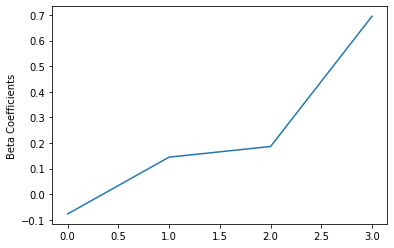

In [13]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

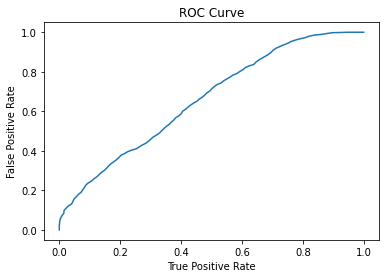

Training set areaUnderROC: 0.6589458528853125


In [14]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [15]:
predictions = lrModel.transform(test)
predictions.select('scaledFeatures', 'Deal_Stage','prediction', 'probability').show(10)

+--------------------+----------+----------+--------------------+
|      scaledFeatures|Deal_Stage|prediction|         probability|
+--------------------+----------+----------+--------------------+
|[0.01792014053808...|         1|       1.0|[0.41009165335827...|
|[0.01792014053808...|         1|       1.0|[0.45686411165641...|
|[0.01879429373506...|         1|       1.0|[0.37455858205529...|
|[0.01923137033355...|         1|       1.0|[0.45780406809477...|
|[0.01923137033355...|         1|       1.0|[0.48418632278085...|
|[0.01966844693204...|         1|       1.0|[0.44833590540186...|
|[0.02010552353053...|         0|       0.0|[0.51181616966673...|
|[0.02010552353053...|         0|       0.0|[0.51336033128938...|
|[0.02010552353053...|         0|       1.0|[0.44510603042372...|
|[0.02010552353053...|         0|       0.0|[0.57883575544596...|
+--------------------+----------+----------+--------------------+
only showing top 10 rows



In [18]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="Deal_Stage")
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.6480506190095842


In [19]:
y_true = predictions.select(['Deal_Stage']).collect()
y_pred = predictions.select(['prediction']).collect()

In [20]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

In [21]:
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.19      0.31       768
           1       0.66      0.97      0.79      1252

    accuracy                           0.68      2020
   macro avg       0.73      0.58      0.55      2020
weighted avg       0.72      0.68      0.61      2020

[[ 149  619]
 [  37 1215]]


In [10]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'scaledFeatures', labelCol = 'Deal_Stage', maxDepth = 8)
dtModel = dt.fit(train)

predictions = dtModel.transform(test)
predictions.select('scaledFeatures', 'Deal_Stage','prediction', 'probability').show(10)

+--------------------+----------+----------+--------------------+
|      scaledFeatures|Deal_Stage|prediction|         probability|
+--------------------+----------+----------+--------------------+
|[0.01792014053808...|         1|       1.0|     [0.1125,0.8875]|
|[0.01792014053808...|         1|       1.0|     [0.1125,0.8875]|
|[0.01879429373506...|         1|       1.0|     [0.1125,0.8875]|
|[0.01923137033355...|         1|       0.0|           [0.5,0.5]|
|[0.01923137033355...|         1|       1.0|[0.11111111111111...|
|[0.01966844693204...|         1|       1.0|[0.11111111111111...|
|[0.02010552353053...|         0|       0.0|           [1.0,0.0]|
|[0.02010552353053...|         0|       0.0|           [1.0,0.0]|
|[0.02010552353053...|         0|       0.0|           [1.0,0.0]|
|[0.02010552353053...|         0|       0.0|           [1.0,0.0]|
+--------------------+----------+----------+--------------------+
only showing top 10 rows



In [11]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="Deal_Stage")
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8296080437965921


In [18]:
y_true = predictions.select(['Deal_Stage']).collect()
y_pred = predictions.select(['prediction']).collect()

In [21]:
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))
print(accuracy_score(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.71      0.83       768
           1       0.85      0.99      0.91      1252

    accuracy                           0.89      2020
   macro avg       0.91      0.85      0.87      2020
weighted avg       0.90      0.89      0.88      2020

[[ 548  220]
 [  11 1241]]
0.8856435643564357


In [23]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'scaledFeatures', labelCol = 'Deal_Stage' ,numTrees=200, maxDepth=8)
rfModel = rf.fit(train)


predictions = rfModel.transform(test)
predictions.select('scaledFeatures', 'Deal_Stage','prediction', 'probability').show(10)

+--------------------+----------+----------+--------------------+
|      scaledFeatures|Deal_Stage|prediction|         probability|
+--------------------+----------+----------+--------------------+
|[0.01792014053808...|         1|       1.0|[0.13437686700645...|
|[0.01792014053808...|         1|       1.0|[0.19744537794944...|
|[0.01879429373506...|         1|       1.0|[0.19086762545513...|
|[0.01923137033355...|         1|       1.0|[0.26204864365004...|
|[0.01923137033355...|         1|       1.0|[0.23340804462922...|
|[0.01966844693204...|         1|       1.0|[0.21797515581109...|
|[0.02010552353053...|         0|       0.0|[0.97965484026372...|
|[0.02010552353053...|         0|       0.0|[0.96168259160984...|
|[0.02010552353053...|         0|       0.0|[0.96620218491904...|
|[0.02010552353053...|         0|       0.0|[0.98077782636180...|
+--------------------+----------+----------+--------------------+
only showing top 10 rows



In [24]:
evaluator = BinaryClassificationEvaluator(labelCol="Deal_Stage")
print('Test Area Under ROC', evaluator.evaluate(predictions))

y_true = predictions.select(['Deal_Stage']).collect()
y_pred = predictions.select(['prediction']).collect()

print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))
print('Accuracy: ', accuracy_score(y_true, y_pred))

Test Area Under ROC 0.9249424878527691
              precision    recall  f1-score   support

           0       0.99      0.72      0.83       768
           1       0.85      1.00      0.92      1252

    accuracy                           0.89      2020
   macro avg       0.92      0.86      0.87      2020
weighted avg       0.90      0.89      0.88      2020

[[ 550  218]
 [   6 1246]]
Accuracy:  0.8891089108910891


In [25]:
rfModel.featureImportances

SparseVector(4, {0: 0.59, 1: 0.0309, 2: 0.3416, 3: 0.0375})

In [26]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(featuresCol = 'scaledFeatures', labelCol = 'Deal_Stage', maxIter=10, maxDepth=10, featureSubsetStrategy='sqrt', minInstancesPerNode=3)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('scaledFeatures', 'Deal_Stage','prediction', 'probability').show(10)

+--------------------+----------+----------+--------------------+
|      scaledFeatures|Deal_Stage|prediction|         probability|
+--------------------+----------+----------+--------------------+
|[0.01792014053808...|         1|       1.0|[0.11679624907723...|
|[0.01792014053808...|         1|       1.0|[0.06882003008126...|
|[0.01879429373506...|         1|       1.0|[0.15083532203045...|
|[0.01923137033355...|         1|       1.0|[0.19891461020209...|
|[0.01923137033355...|         1|       1.0|[0.16282751627125...|
|[0.01966844693204...|         1|       1.0|[0.17732943309099...|
|[0.02010552353053...|         0|       0.0|[0.92946366692386...|
|[0.02010552353053...|         0|       0.0|[0.93856482706043...|
|[0.02010552353053...|         0|       0.0|[0.93447433700074...|
|[0.02010552353053...|         0|       0.0|[0.93393440474241...|
+--------------------+----------+----------+--------------------+
only showing top 10 rows



In [27]:
evaluator = BinaryClassificationEvaluator(labelCol="Deal_Stage")
print('Test Area Under ROC', evaluator.evaluate(predictions))

y_true = predictions.select(['Deal_Stage']).collect()
y_pred = predictions.select(['prediction']).collect()

print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))
print('Accuracy: ', accuracy_score(y_true, y_pred))

Test Area Under ROC 0.9248764476837056
              precision    recall  f1-score   support

           0       0.94      0.74      0.83       768
           1       0.86      0.97      0.91      1252

    accuracy                           0.89      2020
   macro avg       0.90      0.86      0.87      2020
weighted avg       0.89      0.89      0.88      2020

[[ 570  198]
 [  34 1218]]
Accuracy:  0.8851485148514852


In [30]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

layers = [4, 5, 4, 2]
# create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(featuresCol = 'scaledFeatures', labelCol = 'Deal_Stage' , maxIter=100, layers=layers, blockSize=128, seed=1234)

# train the model
model = trainer.fit(train)
predictions = model.transform(test)
predictions.select('scaledFeatures', 'Deal_Stage','prediction', 'probability').show(10)

+--------------------+----------+----------+--------------------+
|      scaledFeatures|Deal_Stage|prediction|         probability|
+--------------------+----------+----------+--------------------+
|[0.01792014053808...|         1|       1.0|[0.38619960979760...|
|[0.01792014053808...|         1|       1.0|[0.38619960979760...|
|[0.01879429373506...|         1|       1.0|[0.38619960979760...|
|[0.01923137033355...|         1|       1.0|[0.38619960979760...|
|[0.01923137033355...|         1|       1.0|[0.38619960979760...|
|[0.01966844693204...|         1|       1.0|[0.38619960979760...|
|[0.02010552353053...|         0|       0.0|[1.0,2.4840244878...|
|[0.02010552353053...|         0|       0.0|[0.99999251343035...|
|[0.02010552353053...|         0|       0.0|[0.99197027079861...|
|[0.02010552353053...|         0|       0.0|[1.0,2.4840243786...|
+--------------------+----------+----------+--------------------+
only showing top 10 rows



In [31]:
evaluator = BinaryClassificationEvaluator(labelCol="Deal_Stage")
print('Test Area Under ROC', evaluator.evaluate(predictions))

y_true = predictions.select(['Deal_Stage']).collect()
y_pred = predictions.select(['prediction']).collect()

print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))
print('Accuracy: ', accuracy_score(y_true, y_pred))

Test Area Under ROC 0.6626512163871138
              precision    recall  f1-score   support

           0       0.96      0.27      0.42       768
           1       0.69      0.99      0.81      1252

    accuracy                           0.72      2020
   macro avg       0.82      0.63      0.61      2020
weighted avg       0.79      0.72      0.66      2020

[[ 204  564]
 [   9 1243]]
Accuracy:  0.7163366336633663
